# Linking field data to imagery to update the Fractional Cover and Ground Cover Models
This is the workbook used to compute the new end-to-end fractional cover model


## Imports

In [1]:
# Imports
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.constraints import max_norm



print("TensorFlow v"+tf.__version__)
print(tf.test.gpu_device_name())



TensorFlow v2.3.0



## Read field and image data

All field data sits on postgres linked to ODK field data capture system.  
Need to first link view below the canopy to view above the canopy.  


In [2]:
CALIBRATION_DATA = '../fielddata/fractionalChips20181204.csv'


def datestr2num(s):
    # Function to convert a date to a timestamp
    return (datetime.datetime.strptime(s,'%d/%m/%Y') - datetime.datetime(1970, 1, 1)).total_seconds()

def sensorNum(s):
    # Function to get the sensor number (Landsat 5, 7 or 8) from a JRSRP filename
    return float(s[1])

def oliToetm(ref):
    # Applies the Flood(2014) coefficients to transform OLI to ETM+
    gain = np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551])
    offset = np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327])
    return offset + gain * ref

interceptData = pd.read_csv(CALIBRATION_DATA,
                        na_values = "nan",
                        sep=",",
                        skipinitialspace=True).sample(frac=1)


# Add timestamp and sensor number to the dataframe
interceptData['fractional.obs_timestamp'] = interceptData['fractional.obs_time'].apply(datestr2num)
interceptData['fractional.obs_sensornum'] = interceptData['fractional_chips.filename'].apply(sensorNum)

# Load Reflectance Data fromthe closest point in time
refData = np.array(interceptData[['fractional_chips.b1_sf_mn',
       'fractional_chips.b2_sf_mn', 'fractional_chips.b3_sf_mn',
       'fractional_chips.b4_sf_mn', 'fractional_chips.b5_sf_mn',
       'fractional_chips.b6_sf_mn']]) / 10000.0

# Convert L8 to L7 so the model is in Landsat 7 spectral space
l8Idx=interceptData['fractional.obs_sensornum'] == 8
refData[l8Idx] = oliToetm(refData[l8Idx])

# Drop out the Blue Band
refData = refData[:,1:]


interceptData.describe()

fractional.longitude  fractional.latitude  fractional.persist  \
count           4000.000000          4000.000000         4000.000000   
mean             138.573456           -23.409382            9.341836   
std                7.599297             5.951202           17.482992   
min              114.042900           -43.474100            0.000000   
25%              133.482100           -26.359905            0.000000   
50%              136.302188           -22.926118            1.667000   
75%              145.241126           -18.850785            9.770000   
max              153.493573           -12.154376           96.800000   

       fractional.crust  fractional.dist  fractional.rock  fractional.green  \
count       4000.000000      4000.000000      4000.000000       4000.000000   
mean          23.827150         3.913605         3.749902         11.069268   
std           22.119588        11.097486         9.837685         16.693403   
min            0.000000         0.000000         0.000000          0.000000   
25%            4.700000         0.000000         0.000000          0.300000   
50%           18.000000         0.000000         0.000000          3.365000   
75%           38.500000         1.000000         1.700000         15.000000   
max          100.000000        92.300000        91.300000         98.500000   

       fractional.dead  fractional.litter  fractional.crypto  ...  \
count      4000.000000        4000.000000        4000.000000  ...   
mean         28.102178          27.822307           1.530470  ...   
std          24.112373          20.680705           4.510842  ...   
min           0.000000           0.000000           0.000000  ...   
25%           7.700000          12.700000           0.000000  ...   
50%          21.800000          23.000000           0.000000  ...   
75%          44.000000          38.000000           0.300000  ...   
max          99.700000          99.000000          60.000000  ...   

       fractional_chips.b2_fc_mn  fractional_chips.b3_fc_mn  \
count                4000.000000                4000.000000   
mean                  121.638972                 147.139556   
std                    20.357411                  20.007356   
min                     0.000000                   0.000000   
25%                   107.222222                 134.888889   
50%                   114.444444                 148.111111   
75%                   130.111111                 161.000000   
max                   198.666667                 200.111111   

       fractional_chips.b4_fc_mn  fractional_chips.b1_fc_sd  \
count                3783.000000                4000.000000   
mean                  110.749229                   3.202734   
std                     5.522479                   2.245103   
min                     0.000000                   0.000000   
25%                   108.000000                   1.832491   
50%                   109.555556                   2.793290   
75%                   112.111111                   4.058215   
max                   157.555556                  55.945300   

       fractional_chips.b2_fc_sd  fractional_chips.b3_fc_sd  \
count                4000.000000                4000.000000   
mean                    2.138532                   3.373628   
std                     2.181136                   2.344532   
min                     0.000000                   0.000000   
25%                     1.099944                   2.024541   
50%                     1.706921                   2.981424   
75%                     2.615245                   4.189935   
max                    85.013434                  48.496150   

       fractional_chips.b4_fc_sd  fractional_chips.count  \
count                3783.000000             4000.000000   
mean                  102.659034                8.999750   
std                    29.107295                0.015811   
min                     0.000000                8.000000   
25%                 

### Function to load the calibration data and return the satellite viewable components 

In [3]:
def fractionalCoverSatView(interceptData):
    nTotal = interceptData['fractional.num_points']
    nUnoccluded = interceptData['fractional.unoccluded']
    # Canopy Layer
    nCanopyBranch = interceptData['fractional.over_b'] * nTotal / 100.0
    nCanopyDead = interceptData['fractional.over_d'] * nTotal / 100.0
    nCanopyGreen = interceptData['fractional.over_g'] * nTotal / 100.0
    nCrown = interceptData['fractional.crn']
    # Midstory Layer
    nMidBranch = interceptData['fractional.mid_b'] * nTotal / 100.0
    nMidGreen = interceptData['fractional.mid_g'] * nTotal / 100.0
    nMidDead = interceptData['fractional.mid_d'] * nTotal / 100.0
    # Ground Layer
    nGroundDeadLitter = (interceptData['fractional.dead'] + interceptData['fractional.litter']) * nUnoccluded / 100.0
    nGroundCrustDistRock = (interceptData['fractional.crust'] + interceptData['fractional.dist'] + interceptData['fractional.rock']) * nUnoccluded / 100.0
    nGroundGreen = interceptData['fractional.green'] * nUnoccluded / 100.0
    nGroundCrypto = interceptData['fractional.crypto'] * nUnoccluded / 100.0
    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nUnoccluded
    groundNPVCover = nGroundDeadLitter / nUnoccluded
    groundBareCover = nGroundCrustDistRock / nUnoccluded
    groundCryptoCover = nGroundCrypto / nUnoccluded
    groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nUnoccluded
    # Work out the ground cover propoetions as seen by the satellite
    satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover
    # Work Out Persistent Fractions
    satPersistentGreen=canopyFoliageProjectiveCover+satMidFoliageProjectiveCover
    persistentNPVFraction=canopyDeadProjectiveCover+canopyBranchProjectiveCover+satMidDeadProjectiveCover+satMidBranchProjectiveCover

    return (totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction)
    
totalPVCover,totalNPVCover,totalBareCover,totalCryptoCover,satPersistentGreen,persistentNPVFraction = fractionalCoverSatView(interceptData)

print  ("Number of sites: %d" % len(totalPVCover))



Number of sites: 4000


## Iteration 1 - Minimal Prediction to assign crypto and detect outliers
The next problem to address is field labeling issues.  
First, cryptogram (or biological soil crusts) are not assigned a "colour" and we need to decide whether to treat them as green or non green. We do this by doing a rough model fit, and then testing where the cryptogram component for each sit best fits.  
There is also an observer bias issue, where in areas of "yellow" grass people will pick non-green or green for the entire site. We check for this by looking for sites with a good bare fit but with a large and opposite error term for the green and non-green. By iterativly adjusting the field estimates across classes we gradually improve the bare estimate.  

In [4]:
# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()

model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[train_dataset.shape[1]]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# Fit the Model 
history = model.fit(train_dataset, train_labels,
                    epochs=2500,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[PrintDot()])

allPredictions = model.predict(train_dataset)
predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

### Guess the cryptogram class by assigning to the class that gives the best fit

In [5]:
# Assign the crypto to the class that improves the error the most    
greenError  = predGreenCover - totalPVCover
nongreenError = predNongreenCover-totalNPVCover

cryptoNongreenIDX = (np.abs(nongreenError) >= np.abs(nongreenError-totalCryptoCover))
cryptoGreenIDX = (np.abs(nongreenError) < np.abs(nongreenError-totalCryptoCover))
totalPVCover[cryptoGreenIDX] = totalPVCover[cryptoGreenIDX] + totalCryptoCover[cryptoGreenIDX]
totalNPVCover[cryptoNongreenIDX] = totalNPVCover[cryptoNongreenIDX] + totalCryptoCover[cryptoNongreenIDX]


print("Nongreen crypto samples = %f" %np.sum(cryptoNongreenIDX))
print("Green crypto samples = %f" %np.sum(cryptoGreenIDX))



Nongreen crypto samples = 3433.000000
Green crypto samples = 567.000000


### Remove potential outliers
There are some outliers in the field data. These seem to be some of the early CHAT sites and also those sites where the groundcover has changes significantly in the days between the measurement.

We detect these by finding those sites where the prediction error is more than 3 standard deviations from zero.

3950


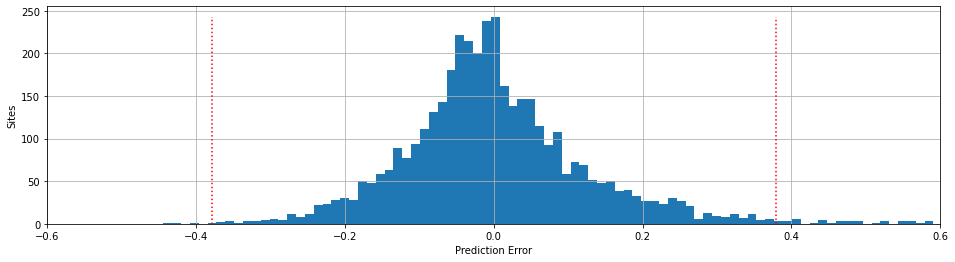

In [6]:
# Find any wild outliers - Typically early CHAT sites or sites where rainfall or grazing rapidly changed the surface
barePredictionError= totalBareCover-predBareCover
anomalyCutoff = np.std(barePredictionError) * 3
isNotOutlierIDX = np.where(np.abs(barePredictionError) < anomalyCutoff)
print(len(isNotOutlierIDX[0]))
totalBareCover = np.array(totalBareCover)[isNotOutlierIDX]
totalPVCover = np.array(totalPVCover)[isNotOutlierIDX]
totalNPVCover = np.array(totalNPVCover)[isNotOutlierIDX]
refData = refData[isNotOutlierIDX]

# Plot the cutoffs
plt.figure(figsize=(16,4))
histData = plt.hist(barePredictionError,bins=100)
plt.xlabel('Prediction Error')
plt.ylabel('Sites')
plt.plot([-anomalyCutoff,-anomalyCutoff],[0,np.max(histData[0])],':r')
plt.plot([anomalyCutoff,anomalyCutoff],[0,np.max(histData[0])],':r')
plt.xlim([-0.6,0.6])
plt.grid()
plt.savefig('../paper/anomaly.png', bbox_inches='tight', facecolor='w')

## Equal Sampling Weighting
Because the samples are not uniformly distributed across the cover space, we set up a histogram based weighting function to make sure those rare sites still contribute to the model.

[2.6464472588289176, -2.996298133423492, 0.9670853447940264, -0.045577298667395384]
[0.2150280660456574, 0.0406563597871685, 0.05403003507622001, 0.005978511403799278]
[-0.571330576159346, 1.4932663582967192, -1.0396242626394914, 0.26541954800572376]


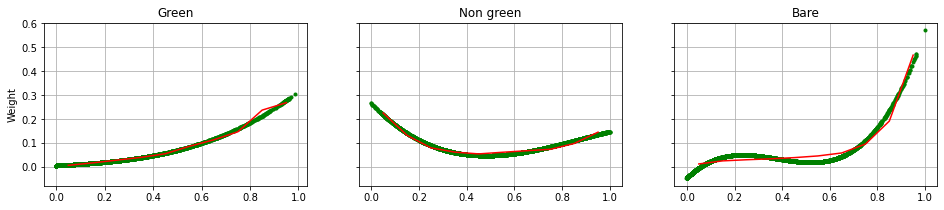

In [10]:
# Weighting by number of points
histoB = np.histogram(totalBareCover,bins=10,range=[0,1])
histoNormB=histoB[0].sum()/histoB[0]
histoNormB /= histoNormB.sum()
bareCoeffs = np.polyfit((histoB[1][1:]+histoB[1][:-1])/2,histoNormB,3)
print(list(bareCoeffs))
bareWeights = np.polyval(bareCoeffs,totalBareCover)

# Weighting by number of points
histoG = np.histogram(totalPVCover,bins=10,range=[0,1])
histoNormG=histoG[0].sum()/histoG[0]
histoNormG /= histoNormG.sum()
greenCoeffs = np.polyfit((histoG[1][1:]+histoG[1][:-1])/2,histoNormG,3)
print(list(greenCoeffs))
greenWeights = np.polyval(greenCoeffs,totalPVCover)

# Weighting by number of points
histoN = np.histogram(totalNPVCover,bins=10,range=[0,1])
histoNormN=histoN[0].sum()/histoN[0]
histoNormN /= histoNormN.sum()
nonGreenCoeffs = np.polyfit((histoN[1][1:]+histoN[1][:-1])/2,histoNormN,3)
print(list(nonGreenCoeffs))
nonGreenWeights = np.polyval(nonGreenCoeffs,totalNPVCover)

sampleWeights = np.transpose([bareWeights,greenWeights,nonGreenWeights])

# Initialise the 1 row 3 column plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,3),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,greenWeights,'g.',(histoG[1][1:]+histoG[1][:-1])/2,histoNormG, 'r-')
ax2.plot(totalNPVCover,nonGreenWeights,'g.',(histoN[1][1:]+histoN[1][:-1])/2,histoNormN, 'r-')
ax3.plot(totalBareCover,bareWeights,'g.',(histoB[1][1:]+histoB[1][:-1])/2,histoNormB, 'r-')
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_ylabel('Weight')
plt.savefig('../paper/weights.png', bbox_inches='tight')

## Build a weighted Loss Function



In [11]:
def histogramWeightedLoss(y_true, y_pred):

    yWeights = tf.transpose([
        tf.math.polyval([2.5503630494066822, -2.8725957463028724, 0.9266315922707328, -0.042580519029573834], y_true[:,0]),
        tf.math.polyval([0.19330273511068435, 0.0734331656396678, 0.04130726627272693, 0.006845783929664368], y_true[:,1]),
        tf.math.polyval([-0.6399469730376368, 1.603853222528618, -1.0914025144200095, 0.27160687026235164], y_true[:,2])
    ])
   
    unmixingError = K.mean(K.abs(y_true * yWeights - y_pred * yWeights),axis=-1)
    negativityError =  K.mean(-y_pred * K.cast(K.less(y_pred,0), K.floatx()),axis=1)
    sum2oneError =  0.005 * K.abs(K.sum(y_pred,axis=1)-1.0)

    loss = unmixingError + sum2oneError + negativityError 
    
    return loss

## Build the Keras Network

In [12]:

# Build the training Labels
train_labels = np.transpose([totalBareCover,totalPVCover,totalNPVCover])
train_dataset = refData.copy()

# Build the model
model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[train_dataset.shape[1]]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            metrics=['mean_absolute_error', 'mean_squared_error']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 35,395
Trainable params: 35,395
Non-trainable params: 0
_________________________________________________________________


## Train the model
Note we set up a couple of callbacks to display progress and stop after a while

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

....................................................................................................
....................................................................................................
....................................................................................................
................................................................................................

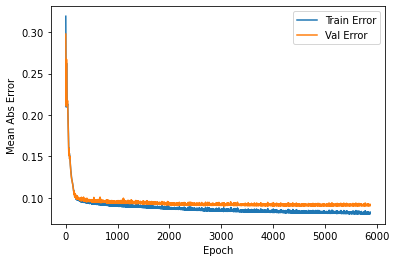

<Figure size 432x288 with 0 Axes>

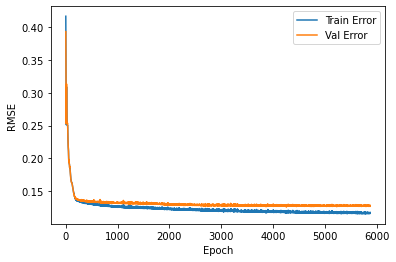

<Figure size 432x288 with 0 Axes>

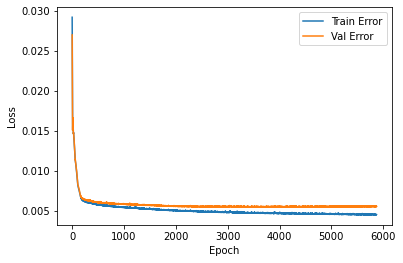

<Figure size 432x288 with 0 Axes>

In [13]:
# Fit the Model 
history = model.fit(train_dataset, train_labels,
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[PrintDot(),
                    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000)])
print('\n')

# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()
  plt.savefig('../paper/trainingMAE.png', bbox_inches='tight', facecolor='w')

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.plot(hist['epoch'], np.sqrt(hist['mean_squared_error']),label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mean_squared_error']),label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.savefig('../paper/trainingMSE.png', bbox_inches='tight', facecolor='w')

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.savefig('../paper/trainingLoss.png', bbox_inches='tight', facecolor='w')


plot_history(history)

## Prediction Plots

Green RMSE = 0.099466
Non Green RMSE = 0.141797
Bare RMSE = 0.119680
Min Bare = 0.002976
Min Green = 0.006719
Min NonGreen = 0.060953


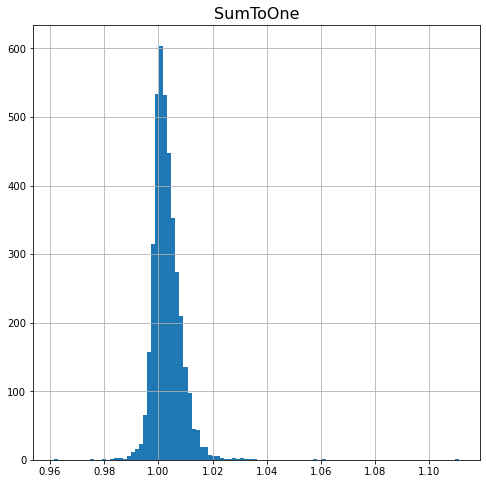

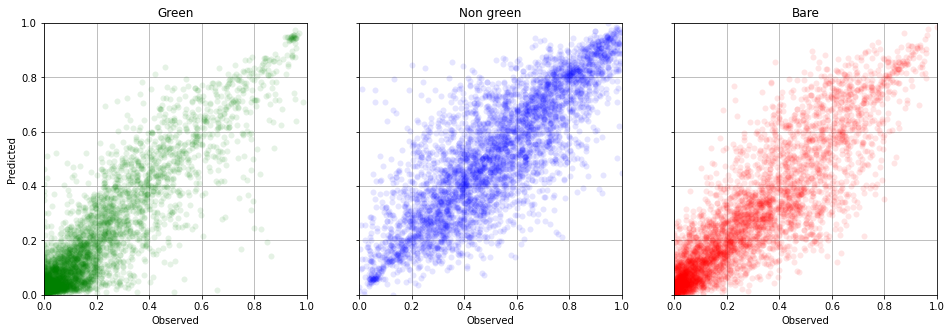

In [16]:
# Predict!
#test_predictions = model.predict(normed_test_data)
allLabels = train_labels
allPredictions = model.predict(train_dataset)

predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "Green RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
print( "Min Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(8,8))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=16)
plt.grid(True)
plt.savefig('../paper/fcSum2one.png', bbox_inches='tight',facecolor='w')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.1,markeredgewidth=0.0)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.1,markeredgewidth=0.0)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.1,markeredgewidth=0.0)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_xlabel('Observed')
ax2.set_xlabel('Observed')
ax3.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
f.savefig('../paper/fcCalibration.png', bbox_inches='tight',facecolor='w')



In [17]:
# Save the model
modelName = '../models/fcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'
model.save(modelName,save_format='h5')
# Save a TFLite version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open(modelName.replace('hd5','tflite'), "wb").write(tflite_model)
print('Saved: ',modelName)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\scart\AppData\Local\Temp\tmpbtqx957w\assets
Saved:  ../models/fcModel_202105241323.hd5


## Assess the stability of the model by running cross validation
We use a 50:50 split run 

In [12]:
maes = []
wmapes = []
rmses = []

for i in range(25):

    X_train, X_test, y_train, y_test = train_test_split( refData.copy(), np.transpose([totalBareCover,totalPVCover,totalNPVCover]), test_size=0.33)
    
    model = keras.Sequential([
        layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[X_train.shape[1]]),
        layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
        layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
        layers.Dense(3)
        ])

    model.compile(loss=histogramWeightedLoss,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) 

    model.fit(X_train, y_train, epochs=5000,
                        validation_split = 0.5,
                        shuffle=True,
                        batch_size=4096,
                        verbose=0)


    # Validation Metrics
    predicted = model.predict(X_test)
    mae = np.median(np.abs(predicted - y_test), axis = 0)
    maes.append(mae)
    #mape = np.mean(np.abs((predicted - y_test) / (y_test + np.finfo(float).eps)), axis = 0)
    wmape = np.sum(np.abs(predicted - y_test), axis = 0) / np.sum(np.abs(y_test), axis = 0)
    wmapes.append(wmape)
    rmse = np.sqrt(np.mean((predicted - y_test)**2.0,  axis = 0))
    rmses.append(rmse)
    print(mae,wmape,rmse)

    
maes = np.array(maes)
wmapes = np.array(wmapes)
rmses = np.array(rmses)
print(maes.mean(axis=0),maes.std(axis=0))
print(wmapes.mean(axis=0),wmapes.std(axis=0))
print(rmses.mean(axis=0),rmses.std(axis=0))

KeyboardInterrupt: 

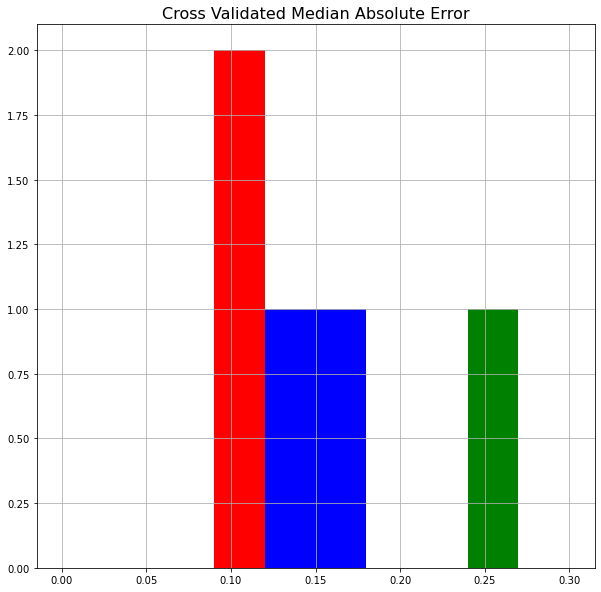

In [39]:
fig = plt.figure(figsize=(10,10))
plt.hist(maes[1], bins=10, color="green", range=(0.0,0.3) )
plt.hist(maes[2], bins=10, color="blue", range=(0.0,0.3) )
plt.hist(maes[0], bins=10, color="red", range=(0.0,0.3) )
plt.title('Cross Validated Median Absolute Error', fontsize=16)
plt.grid(True)
plt.savefig('../paper/madError.png', bbox_inches='tight', facecolor='w')

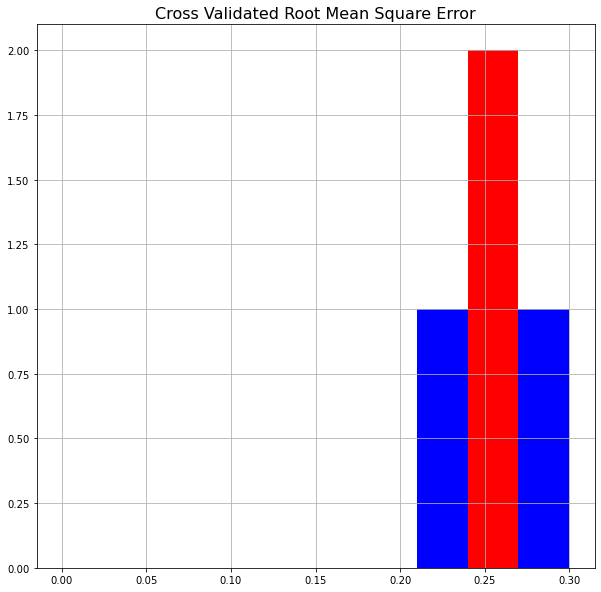

In [38]:
fig = plt.figure(figsize=(10,10))
plt.hist(rmses[1], bins=10, color="green", range=(0.0,0.3))
plt.hist(rmses[2], bins=10, color="blue", range=(0.0,0.3) )
plt.hist(rmses[0], bins=10, color="red", range=(0.0,0.3) )
plt.title('Cross Validated Root Mean Square Error', fontsize=16)
plt.grid(True)
plt.savefig('../paper/rmsError.png', bbox_inches='tight',facecolor='w')

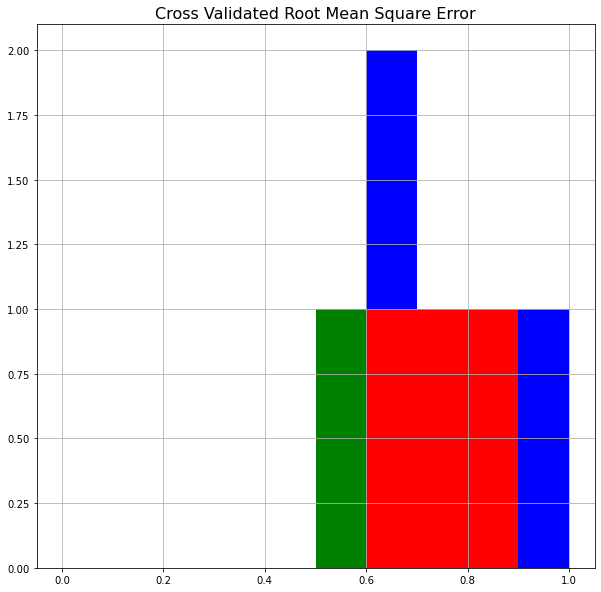

In [40]:
fig = plt.figure(figsize=(10,10))
plt.hist(wmapes[1], bins=10, color="green", range=(0.0,1.0))
plt.hist(wmapes[2], bins=10, color="blue", range=(0.0,1.0) )
plt.hist(wmapes[0], bins=10, color="red", range=(0.0,1.0) )
plt.title('Cross Validated Root Mean Square Error', fontsize=16)
plt.grid(True)
plt.savefig('../paper/rmsError.png', bbox_inches='tight', facecolor='w')

## And check that the model runs!

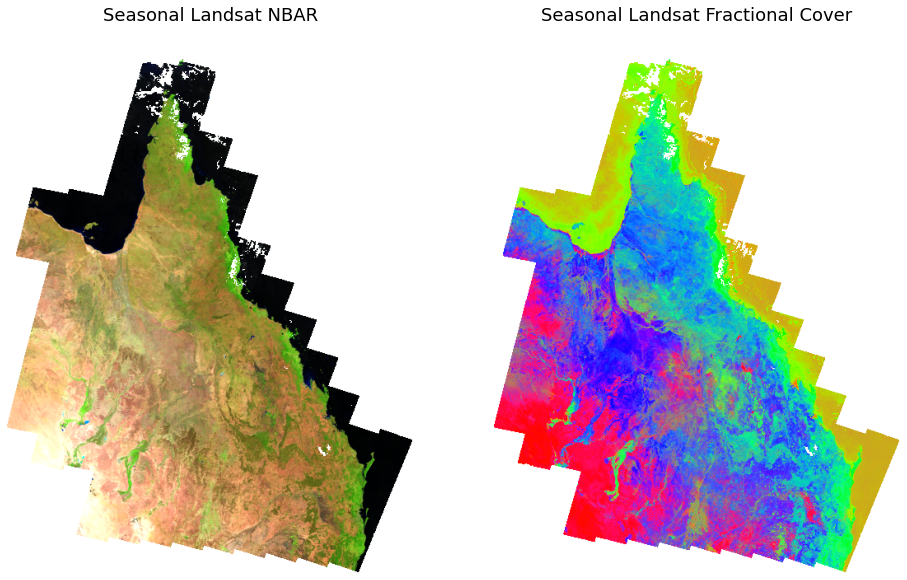

In [68]:
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# The unmixing model
def unmixfc(nbar, fcModel):
    # Get the shape of the input array
    inshape = nbar.shape
    # Flatten and scale reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0

    # Convert Landsat 8 if required
    nbar = np.transpose(np.transpose(nbar) * 
                        np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551]) + 
                        np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327]))

    # Convert Sentinel 2 if required
    #nbar = np.transpose(np.transpose(nbar[[0,1,2,3,8,9]]) * 
    #                   np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + 
    #                  np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))

    # Drop the Blue band. Blue is yukky
    refData = np.transpose(nbar[1:])

    # Run the prediction
    fcLayers = np.clip(fcModel.predict(refData)[:,0:3].T,0,2)
    fcLayerSum = fcLayers.sum(axis=0) + np.finfo('float32').eps
    # Clip Output
    outputFC = np.round(100 * fcLayers/fcLayerSum, 0)
    # Correct noData
    outputFC[:,nbar[0] < 0.001] = 255
    outputFC[:,nbar[0] > 0.999] = 255
    # Reshape the FC Output
    return np.reshape(outputFC,(3,inshape[1],inshape[2])).astype(np.uint8),fcLayers


# Connect to the seasonal surface reflectance
dataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/qld/l8olre_qld_m201906201908_dbia2.tif'
# Open the data set
refDataSet = rasterio.open(dataPath)
# Read in the imagery at an overview level
overviewLevel = 128
refData = np.ma.masked_equal(refDataSet.read(
    out_shape=(refDataSet.count,
               int(refDataSet.height / overviewLevel),
               int(refDataSet.width / overviewLevel))),
               refDataSet.nodatavals[0])

# Run the prediction
fcModel = tf.keras.models.load_model(modelName,compile=False)
fcImage,fcLayers = unmixfc(refData,fcModel)

# Plot the images
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,16),sharey=True)
# Plot the three fractions
ax1.imshow(
    np.rollaxis(
        np.clip(refData[[4,3,2]] / 4000.0 * 255.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax1.set_title('Seasonal Landsat NBAR', fontsize=18)
ax1.axis('off');

ax2.imshow(
    np.rollaxis(
        np.clip(fcImage / 100.0 * 400.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax2.set_title('Seasonal Landsat Fractional Cover', fontsize=18)
ax2.axis('off');

f.savefig('fcPredictions.png', bbox_inches='tight')


## Crypto Analysis